In [ ]:
## Background ##
# Recent research suggested that non-invasive brain stimulation can lead to clinical improvements
# in patients with vegetative or minimally conscious state. However, the outcomes 
# of the studies have been inconsistent. One possible explanation to this inconsistency in findings
# is related to the great heterogeneity of brain damage inherent to vegetative state patients. 
# In fact, lesions and atrophies might influence brain stimulation-induced current distribution,
# which, in turn, would impact the stimulation outcome. 

# To investigate this issue, I analysed the relationship between stimulation-induced
# current density characteristics in the healthy brain, and stimulation-induced brain network changes.

## BriefIntroduction to the script ##
# Magnetic Resonance Imaging (MRI) anatomical scans of 64 subjects were pooled from three neuroimaging experiments,
# which I had previously published (focusing on the connectivity changes).
# The structural data was used to compute stimulation-induced electric fields (magnitude and direction) for each participant. 
# Current density data was also computed.
# Current density data and electric- field data for each participant were stored in three-dimensional numpy arrays.

# In this notebook, I visualised current density data for all participants of one of the three datasets,
# for publication purposes (script N.1).
# Moreover, I wrote a function that allows me to plot specific slices of electric field data, displaying
# both the magnitude of the electric field at each voxel, and its direction (script N.2). The function can be 
# found below, followed by an example of its implementation.


import os
from nilearn import image, plotting
from nilearn.image import new_img_like
import matplotlib as mpl
import matplotlib.pyplot as plt

results_folder = 'D:\\roast-chapter3\\wp_all_results\\' # location of e-field and current density maps

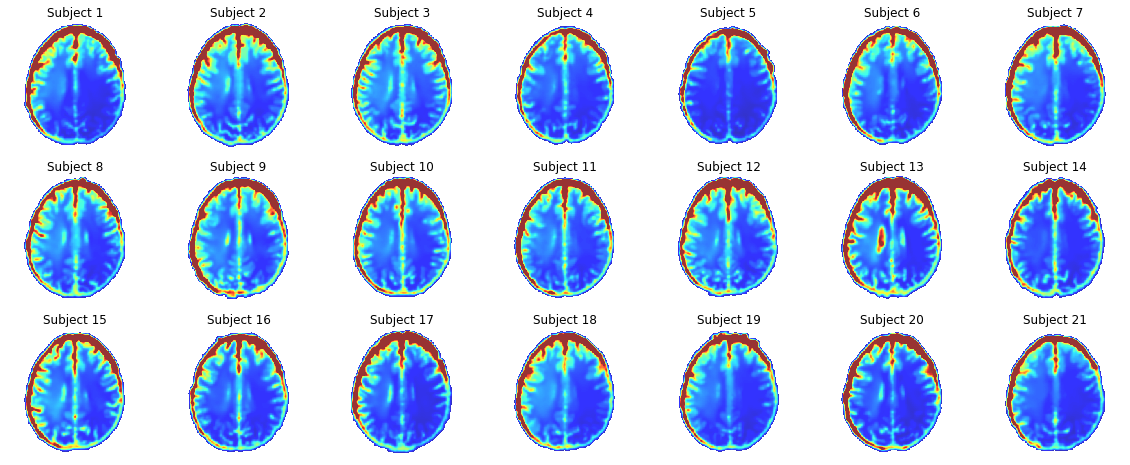

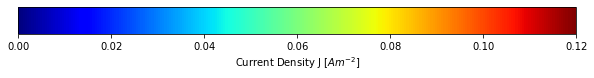

In [11]:
## Script N. 1: Current density  plot
db_names = ['wp1a'] # names of the datasets to display
save_plt = True

# Current density color map vmin, vmax and threshold
cd_vmin = 0
cd_vmax = 0.12
cd_threshold = 0.005 

for db_id, db in enumerate(db_names):
    
    fig, axes = plt.subplots(nrows = 3, ncols = 7, figsize = (20,8)) # Initiating the plot
    vmin, vmax = 0, 0.35 # Color map min and max. 
    cd_scans = image.load_img(os.path.join(results_folder +  db + '_all_cd_maps.nii'))

    # Iterating subjects
    for i, ax in enumerate(axes.flatten()):
        display = plotting.plot_roi(new_img_like(cd_scans, cd_scans.get_fdata()[:,:,:,i]),
                bg_img = None,
                display_mode = 'z',
                annotate = False,
                cmap = 'jet',
                cut_coords = [30],
                threshold = cd_threshold,
                vmin = cd_vmin,
                vmax = cd_vmax,
                alpha = 0.80,
                draw_cross = False,
                black_bg = False,
                axes = ax)
        ax.title.set_text('Subject ' + str(i + 1))

    if save_plt:
        plt.savefig(db + '_cd_all.jpg', format='jpg', dpi=400)

    # Adding a colorbar for the above plots
    fig, ax = plt.subplots(figsize=(10, 1))
    fig.subplots_adjust(bottom=0.5)
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=cd_vmin, vmax=cd_vmax)

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax, orientation='horizontal', label='Current Density J [$Am^{-2}$]')    
    if save_plt:
        plt.savefig(db + '_cd_all_cbar.jpg', format='jpg', dpi=400)

In [12]:
# Script N.2
# This function allows to visualise specific slices of electric field data, displaying
# both the magnitude of the electric field at each voxel, and its direction. 
# An implementation of the function is provided in the below cell. 

"""
Author: Davide Aloi - PhD student - University of Birmingham - Centre for Human Brain Health
"""

import glob, os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from scipy.spatial.transform import Rotation as R

def roast_vector_sim(e: np.ndarray, e_mag: np.ndarray, mask: np.ndarray, vmin = 0,
                     vmax = 0.35, vmin_v = 0.1, vmax_v = 2, axis = 2, which_slice = 0,
                     subsample = 2, scale = 3, figsize = (30,30)):
    """
    Description:
        Plots results from electric field maps generated by ROAST, masked using a brain mask.

        Parameters
    ----------
    e : np.ndarray
        electric field vectors map.
    e_mag : np.ndarray
        electric field magnigute map.
    mask : np.ndarray
        Brain mask map. It should contain only 0 and 1. I will be used to mask the data.
    vmin : TYPE, optional
        vmin for electric field magnitude cmap. The default is 0.
    vmax : TYPE, optional
        vmax for electric field magnitude cmap. The default is 0.35.
    vmin_v : TYPE, optional
        vmin electric field vectors under this threshold won't be shown. The default is 0.1.
    vmax_v : TYPE, optional
        vmin electric field vectors above this threshold won't be shown. The default is 2.
    axis : TYPE, optional
        Which axis to plot. 0 = axial, 1 = coronal, 2 = sagittal. The default is 2.
    which_slice : TYPE, optional
        Slice of the scan to plot. The default is 0.
    subsample : TYPE, optional
        Removing vectors every N elements. It avoids overcrowded plots. The default is 2.
    scale : TYPE, optional
        Factor of scale for the vectors. Higher -> smaller vectors. The default is 3.
    figsize: int, optional
        size of the matplotlib plot

        Returns
     ----------
     matplotlib plot

    Raises
    ------
    Exception
        Scans should all have the same dimension.
        Axis can only be 0, 1 or 2.
        which_slice should not exceed scan dimension on plotted plane.
    """


    if (e.shape[0:3] != mask.shape != mask.shape):
        raise Exception("Electric field map and mask should have the same dimension.")

    if not np.isin(axis, [0, 1, 2]):
        raise Exception("Invalid axis. Axis can only be equal to 0 (x) 1 (y) or 2 (z).")


    if e_mag.shape[axis] > which_slice:
        
        if axis == 0:  
            # Flipping left -> right (x axis)
            e_mag = np.flip(e_mag, 0)
            e = np.flip(e, 0)
            e_mag = np.where(mask[which_slice, :, :] != 0, e_mag[which_slice, :, :], 0)
            x = -e[which_slice,:,:, 0]
            y = -e[which_slice,:,:, 1]
            
        if axis == 1:
            e_mag = np.where(mask[:, which_slice, :] != 0, e_mag[:, which_slice, :], 0)
            e_mag = np.flip(np.rot90(e_mag),-1) # flipping x axis
            x = e[:,which_slice,:, 0]
            y = e[:,which_slice,:, 2]
            x = np.flip(np.rot90(x),-1)
            y = np.flip(np.rot90(y),-1)
            
        if axis == 2:
            e_mag = np.where(mask[:, :, which_slice] != 0, e_mag[:, :, which_slice], 0)
            e_mag = np.flip(e_mag, 0) # flipping y axis 
            x = np.flip(e[:,:,which_slice, 1], 0)
            y = np.flip(e[:,:,which_slice, 2], 0)

         
        idxs = np.zeros(x.ravel().size, bool)
        idxs[::subsample] = 1
        idxs = np.where(((e_mag.ravel() > vmin_v) & (e_mag.ravel() < vmax_v)) & (idxs == 1), 1, 0)
        idxs = idxs.reshape(x.shape)
        x = np.where(idxs == 1, x, np.nan)
        y = np.where(idxs == 1, y, np.nan)

        f, ax = plt.subplots(figsize=figsize)
        ax.imshow(e_mag, cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
        ax.quiver(x, y, scale = scale,
                   minlength = 2,
                   headwidth = 3, headlength = 3, alpha = 0.7,
                   linewidth = 0.2)
        ax.axis('off')

        return ax

    else:
        raise Exception("Slice chosen exceeds scan dimension on chosen axis (" + str(axis) + ")\n"
                        "Scan shape: " + str(e_mag.shape) + "\n"
                        "Sclice chosen: " + str(which_slice))

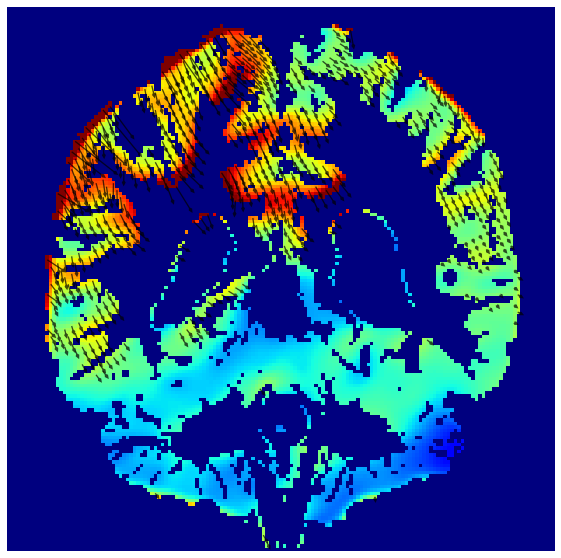

In [17]:
# Electric field vector map plot using roast_vector_sim - Example for Subject 1

from custom_functions.plotting_functions import roast_vector_sim
import glob, os
from nilearn import image, plotting
from nilearn.image import new_img_like
from matplotlib import pyplot as plt

# Loading all the necessary data 
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' 
path = 'D:\\roast-chapter3\\wp2a\\sub-01'
e_v = image.load_img(glob.glob(path + '/wT1_cleaned*_e.nii')) # Electric field vectors
emag = image.load_img(glob.glob(path + '/wT1_cleaned*_emag.nii')) # Electric field magnitude
scan_shape = emag.get_fdata().shape[0:3] # Shape of the scan
mni = image.load_img(os.path.join(main_folder, 'rois', 'MNI152_T1_1mm_Brain.nii')) # Brain mask
mni_resampled = image.resample_to_img(mni, emag, interpolation = 'nearest')
emag_data = emag.get_fdata().reshape(scan_shape) # Data with 4th dimention in the array dropped
emag_map = new_img_like(emag, emag_data) #  Restoring the data into a 3D nibabel object

# We are interested in visualising e-field vectors for voxels associated to grey matter only.
# Each participant has a 3D scan where each voxel has an associated tissue type (i.e.,
# white matter == 1, grey matter == 2, cerebrospinal fluid == 3 etc.)
mask_data = image.load_img(glob.glob(path + '/wT1_cleaned*masks.nii')).get_fdata() # Participant mask 
mask = new_img_like(emag_map, mask_data.reshape(scan_shape)) # Data with 4th dimention in the array dropped
mask_touched = image.math_img("(np.where(img == 2, 1,0))*np.where(img2 !=0, 1,0)",
                              img = mask,
                              img2 = mni_resampled)

# Smoothing the data: applying a gaussian filter with full width half maximum of 4
emag_map = image.smooth_img(emag_map, fwhm = 4)
e_v = image.smooth_img(e_v, fwhm = 4)

# We can now visualise a slice of the electric field and its vector, for the grey matter
# only of participant 01. We will display the coronal plane and then the axial plane. 
fig = roast_vector_sim(e_v.get_fdata(), emag_map.get_fdata(), mask_touched.get_fdata(),
                 axis = 1,
                 vmin = 0, vmax = 0.16,
                 vmax_v = 0.5,
                 subsample = 5,
                 vmin_v = 0.08,
                 which_slice = 68,
                 scale = 4,
                 figsize=(10,10))
plt.show(fig)

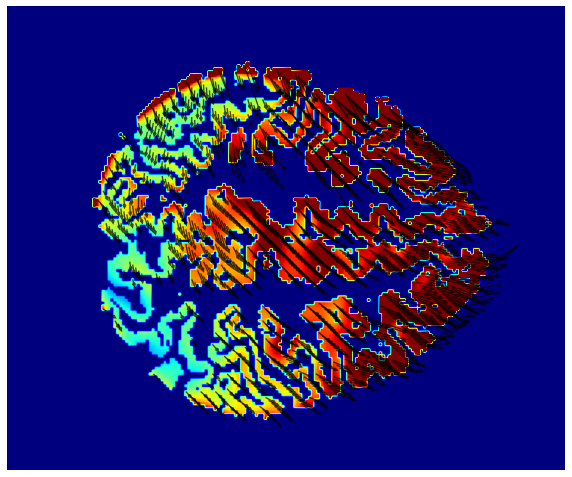

In [9]:
# Example with the axial plane
fig = roast_vector_sim(e_v.get_fdata(), emag_map.get_fdata(), mask_touched.get_fdata(),
                 axis = 2,
                 vmin = 0, vmax = 0.16,
                 vmax_v = 0.5,
                 subsample = 5,
                 vmin_v = 0.08,
                 which_slice = 120, #68
                 scale = 4,
                 figsize=(10,10))
plt.show(fig)